In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'finding-lungs-in-ct-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1172%2F2106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T083804Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f3c63404ee802a28cafad064a8a240b5da2f5e90d91b0854752d9b08d123031e4e9597dc40bd5d245dc25c911076cb7b6ec3c75a132f296c3d14b1e2799ea6b36ad51f64f5bef58d9d2908b811b9c3537752a6af4595f68b8363cd0dd41404b86561a255d9015ae54d152336826a4e748d0ca25e3b88e8b2efcdcba3652cc4f4636929cb1e4ce22983e0e63e6686de3d1eb620388f761ceef68fb149ed258810bc20dc10891dcaa9a79f5b31aff3870dafacda106664467cb0f087e97f00354acdaabb7dc76a4ab5b6137382197008016e76c6d885f076b39d75d8b905cef3878fafdb69e215e0b4b5ca96f8820dcf4838b1fbd66f6badf83d2f65c23d100d2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1108422436 bytes downloaded
Downloaded and uncompressed: finding-lungs-in-ct-data
Data source import complete.


## Extract Data

In [2]:
import zipfile

with zipfile.ZipFile("/kaggle/input/finding-lungs-in-ct-data/2d_images.zip", mode="r") as file:
    file.extractall(path="/kaggle/working/images")

with zipfile.ZipFile("/kaggle/input/finding-lungs-in-ct-data/2d_masks.zip", mode="r") as file:
    file.extractall(path="/kaggle/working/mask")

In [3]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os
import cv2
import numpy as np
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


seed = 42

tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
img_dir_ = "/kaggle/working/images"
msk_dir = "/kaggle/working/mask"

In [5]:
def Load_Image(img_dir, name):
    img_lnk = sorted(os.listdir(img_dir))
    image_ = []
    for img in tqdm(img_lnk, desc=f"Loading {name}", total=len(img_lnk)):
        load_image = keras.utils.load_img(os.path.join(img_dir, img), target_size=(224, 224), color_mode="rgb")
        image_.append(load_image)

    return np.array(image_)

In [6]:
image = Load_Image(img_dir_, "Image")
mask = Load_Image(msk_dir, "Mask")

Loading Mask: 100%|██████████| 267/267 [00:00<00:00, 959.04it/s]


In [7]:
image.shape

(267, 224, 224, 3)

## EDA

(-0.5, 223.5, 223.5, -0.5)

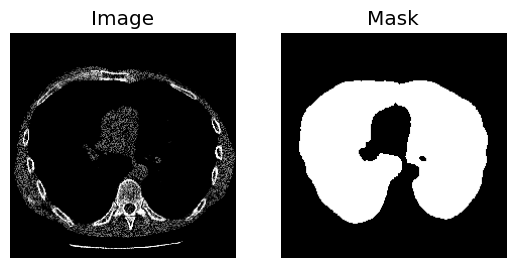

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(image[1])
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask[1])
plt.title("Mask")
plt.axis("off")

## Modelling

In [9]:
def data_preprocessing():
    data_augmentation = keras.Sequential([
        keras.layers.Rescaling(scale=1/255),
        keras.layers.RandomBrightness(factor=.1),
        keras.layers.RandomFlip(mode="horizontal"),
    ])
    return data_augmentation

In [10]:
# Input Layer
input_layer = keras.Input(shape=(224, 224, 3))
# Rescale
rescale_layer = data_preprocessing()(input_layer)

# 1st Encoder
e1 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(rescale_layer)
e1 = keras.layers.BatchNormalization()(e1)
e1 = keras.layers.ReLU()(e1)
e1 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(e1)
e1 = keras.layers.BatchNormalization()(e1)
e1 = keras.layers.ReLU()(e1)
e1 = keras.layers.MaxPooling2D()(e1)

# 2nd Encoder
e2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(e1)
e2 = keras.layers.BatchNormalization()(e2)
e2 = keras.layers.ReLU()(e2)
e2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(e2)
e2 = keras.layers.BatchNormalization()(e2)
e2 = keras.layers.ReLU()(e2)
e2 = keras.layers.MaxPooling2D()(e2)

# 3rd Encoder
e3 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(e2)
e3 = keras.layers.BatchNormalization()(e3)
e3 = keras.layers.ReLU()(e3)
e3 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(e3)
e3 = keras.layers.BatchNormalization()(e3)
e3 = keras.layers.ReLU()(e3)
e3 = keras.layers.MaxPooling2D()(e3)

# 4th Encoder
e4 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(e3)
e4 = keras.layers.BatchNormalization()(e4)
e4 = keras.layers.ReLU()(e4)
e4 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(e4)
e4 = keras.layers.BatchNormalization()(e4)
e4 = keras.layers.ReLU()(e4)
e4 = keras.layers.MaxPooling2D()(e4)

x = keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same")(e4)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D()(x)

d1 = keras.layers.UpSampling2D()(x)

c1 = keras.layers.concatenate([d1, e4])

d1 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(c1)
d1 = keras.layers.BatchNormalization()(d1)
d1 = keras.layers.ReLU()(d1)
d1 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(d1)
d1 = keras.layers.BatchNormalization()(d1)
d1 = keras.layers.ReLU()(d1)

d1 = keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same")(d1)
d1 = keras.layers.BatchNormalization()(d1)
d1 = keras.layers.ReLU()(d1)
d1 = keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same")(d1)
d1 = keras.layers.BatchNormalization()(d1)
d1 = keras.layers.ReLU()(d1)

d2 = keras.layers.UpSampling2D()(d1)

c2 = keras.layers.concatenate([d2, e3])

d2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(c2)
d2 = keras.layers.BatchNormalization()(d2)
d2 = keras.layers.ReLU()(d2)
d2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(d2)
d2 = keras.layers.BatchNormalization()(d2)
d2 = keras.layers.ReLU()(d2)

d3 = keras.layers.UpSampling2D()(d2)

c3 = keras.layers.concatenate([d3, e2])

d3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(c3)
d3 = keras.layers.BatchNormalization()(d3)
d3 = keras.layers.ReLU()(d3)
d3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(d3)
d3 = keras.layers.BatchNormalization()(d3)
d3 = keras.layers.ReLU()(d3)

d4 = keras.layers.UpSampling2D()(d3)

c4 = keras.layers.concatenate([d4, e1])

d4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(c4)
d4 = keras.layers.BatchNormalization()(d4)
d4 = keras.layers.ReLU()(d4)
d4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(d4)
d4 = keras.layers.BatchNormalization()(d4)
d4 = keras.layers.ReLU()(d4)

d5 = keras.layers.UpSampling2D()(d4)

output = keras.layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding="same")(d5)

unet_model = keras.Model(inputs=input_layer, outputs=output)

unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 128)        3584      ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 128)        512       ['conv2d[0][0]']              
 Normalization)                                                                               

In [11]:
unet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
unet_model.fit(image, mask, validation_split=.1, epochs=20)

Epoch 1/20
8/8 [==============================] - 83s 5s/step - loss: 173.5381 - accuracy: 0.5024 - val_loss: 463.0315 - val_accuracy: 0.8585
Epoch 2/20
8/8 [==============================] - 6s 760ms/step - loss: -254.8393 - accuracy: 0.3371 - val_loss: 391.9285 - val_accuracy: 0.9107
Epoch 3/20
8/8 [==============================] - 6s 755ms/step - loss: -329.2225 - accuracy: 0.2126 - val_loss: 360.9716 - val_accuracy: 0.9726
Epoch 4/20
8/8 [==============================] - 6s 740ms/step - loss: -440.0802 - accuracy: 0.2700 - val_loss: 347.2777 - val_accuracy: 0.9915
Epoch 5/20
8/8 [==============================] - 6s 739ms/step - loss: -514.5911 - accuracy: 0.4007 - val_loss: 333.2874 - val_accuracy: 0.9954
Epoch 6/20
8/8 [==============================] - 6s 731ms/step - loss: -558.5368 - accuracy: 0.4395 - val_loss: 307.8383 - val_accuracy: 0.9954
Epoch 7/20
8/8 [==============================] - 6s 747ms/step - loss: -709.3359 - accuracy: 0.3528 - val_loss: -20.6159 - val_accur

## Model Validation

1/1 [==============================] - 3s 3s/step


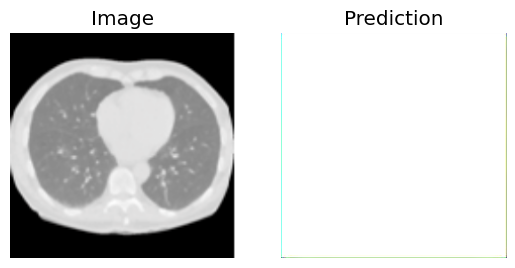

In [15]:
validation_image = "/content/Screenshot 2024-03-26 133655.png"

plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(validation_image), cv2.COLOR_BGR2RGB), (224, 224)))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(unet_model.predict(np.expand_dims(cv2.resize(cv2.cvtColor(cv2.imread(validation_image), cv2.COLOR_BGR2RGB), (224, 224)), axis=0)).reshape(224, 224, 3))
plt.title("Prediction")
plt.axis("off")

plt.show()

In [16]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [17]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [18]:
unet = sm.Unet(
               input_shape=(224, 224, 3),
               classes=3,
               activation="softmax",
               encoder_weights="imagenet",
               encoder_freeze=True)

unet.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                           

In [19]:
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
unet.fit(x=image,
         y=mask,
         validation_split=.1,
         epochs=20)

Epoch 1/20
8/8 [==============================] - 59s 4s/step - loss: -6.7601 - accuracy: 0.5662 - val_loss: 6.1647 - val_accuracy: 0.5883
Epoch 2/20
8/8 [==============================] - 3s 396ms/step - loss: -18.5182 - accuracy: 0.5706 - val_loss: -4.2756 - val_accuracy: 0.5685
Epoch 3/20
8/8 [==============================] - 3s 383ms/step - loss: -26.7811 - accuracy: 0.5708 - val_loss: -15.1719 - val_accuracy: 0.5846
Epoch 4/20
8/8 [==============================] - 3s 382ms/step - loss: -34.3355 - accuracy: 0.5709 - val_loss: -26.1401 - val_accuracy: 0.6019
Epoch 5/20
8/8 [==============================] - 3s 399ms/step - loss: -41.9909 - accuracy: 0.5693 - val_loss: -39.6821 - val_accuracy: 0.6199
Epoch 6/20
8/8 [==============================] - 3s 398ms/step - loss: -50.2219 - accuracy: 0.5684 - val_loss: -55.9365 - val_accuracy: 0.6223
Epoch 7/20
8/8 [==============================] - 3s 397ms/step - loss: -58.5714 - accuracy: 0.5684 - val_loss: -73.3304 - val_accuracy: 0.630

## Model Evaluation

1/1 [==============================] - 2s 2s/step


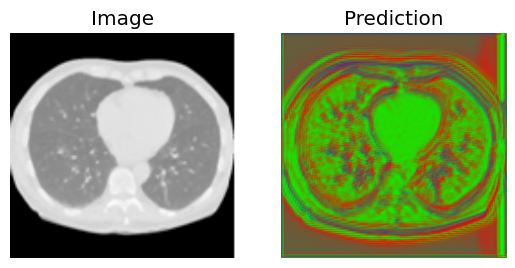

In [23]:
validation_image = "/content/Screenshot 2024-03-26 133655.png"

plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(validation_image), cv2.COLOR_BGR2RGB), (224, 224)))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(unet.predict(np.expand_dims(cv2.resize(cv2.cvtColor(cv2.imread(validation_image), cv2.COLOR_BGR2RGB), (224, 224)), axis=0)).reshape(224, 224, 3))
plt.title("Prediction")
plt.axis("off")

plt.show()

## Color Clustering using Kmean (cv2 and sklearn)

In [24]:
image_color = image[0].reshape(-1, 3)

image_color.shape

(50176, 3)

In [25]:
criteria  = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1)

In [26]:
retval, bestLabels, centers = cv2.kmeans(data=np.float32(image_color), K=10, bestLabels=None, criteria=criteria, attempts=10, flags=cv2.KMEANS_PP_CENTERS)

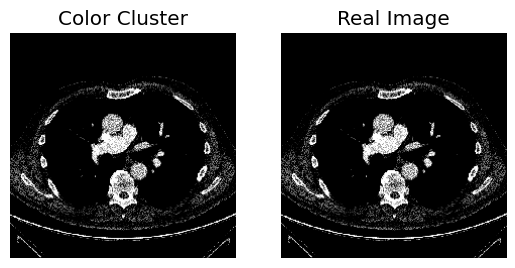

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(np.uint8(centers)[bestLabels.flatten()].reshape(image[0].shape))
plt.title("Color Cluster")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image[0])
plt.title("Real Image")
plt.axis("off")

plt.show()

In [28]:
!pip install imgaug

## Data Augmentation

In [29]:
import imgaug
from imgaug import augmenters

In [30]:
data_augmentation = augmenters.Sequential([
                                    augmenters.Affine(rotate=(-25, 25)),
                                    augmenters.AdditiveGaussianNoise(scale=(10, 100)),
                                    augmenters.KMeansColorQuantization(),
                                    augmenters.HorizontalFlip(),
                                    augmenters.ContrastNormalization(),
                                ], random_order=False)

augmented_images = [data_augmentation(image=image[1]) for _ in range(1, 9)]

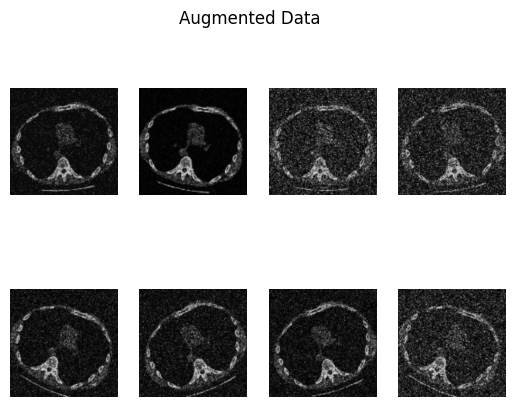

In [31]:
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(augmented_images[i-1])
    plt.axis("off")

plt.suptitle("Augmented Data")
plt.show()

## Modelling

In [32]:
# def ImageGenerator(X, y, batch_size, augment_data=True, replace=False):
#     loop = True
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1)

#     while loop:
#         indices = np.random.choice(len(X), batch_size, replace=replace)
#         img, msk = [], []
#         for idx in indices:
#             retval, bestLabels, centers = cv2.kmeans(np.float32(X[idx].reshape(-1, 3)), K=10, bestLabels=None, criteria=criteria, attempts=10, flags=cv2.KMEANS_PP_CENTERS)
#             clustered_image = np.uint8(centers)[bestLabels.flatten()].reshape(X[idx].shape)

#             if augment_data:
#                 augmented_images = [data_augmentation(image=clustered_image) for _ in range(1, 11)]
#                 augmented_msk = [data_augmentation(image=y[idx]) for _ in range(1, 11)]
#                 img.extend(augmented_images)
#                 msk.extend(augmented_msk)
#             else:
#                 img.append(clustered_image)
#                 msk.append(y[idx])

#         yield np.array(img), np.array(msk)

In [33]:
# batch_img, batch_msk = next(ImageGenerator(image, mask, 32, False))

In [64]:
# plt.subplot(1, 2, 1)
# plt.imshow(batch_img[0])
# plt.title("Image")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(batch_msk[0])
# plt.title("Mask")
# plt.axis("off")

# plt.show()

In [35]:
unet = sm.Unet(backbone_name="mobilenetv2",
               input_shape=(224, 224, 3),
               classes=3,
               activation="softmax",
               encoder_weights="imagenet",
               encoder_freeze=True)

9406464/9406464 [==============================] - 1s 0us/step


In [36]:
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

## Split Data

In [37]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(image, mask, test_size=.2)

In [38]:
print(Xtrain.shape, Xtest.shape)

(213, 224, 224, 3) (54, 224, 224, 3)


In [41]:
# train_gen = ImageGenerator(Xtrain, ytrain, 32, False)
# test_gen = ImageGenerator(Xtest, ytest, 32, False, True)

In [42]:
# unet.fit(train_gen,
#          validation_data=test_gen,
#          epochs=20)

In [43]:
def preprocess_function(x):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1)
  retval, bestLabels, centers = cv2.kmeans(np.float32(x.reshape(-1, 3)), K=10, bestLabels=None, criteria=criteria, attempts=10, flags=cv2.KMEANS_PP_CENTERS)
  preprocessed_image = np.uint8(centers)[bestLabels.flatten()].reshape(x.shape)
  return preprocessed_image

In [51]:
img_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_function,
                                                         width_shift_range=0.1,
                                                         height_shift_range=0.1,
                                                         rotation_range=10,
                                                         zoom_range=0.1)

In [67]:
Xtrain = Xtrain/255
Xtest = Xtest/255
ytrain = ytrain/255
ytest = ytest/255

In [71]:
train_gen = img_gen.flow(Xtrain, ytrain)
test_gen = img_gen.flow(Xtrain, ytrain)

In [75]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=Xtrain.shape[1:],
                        padding='same'
                        ))
model.add(keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=Xtrain.shape[1:],
                        padding='same'
                        ))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Conv2D(filters=1,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=Xtrain.shape[1:],
                        padding='same'
                        ))
model.add(keras.layers.UpSampling2D(size=(2,2)))

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dense (Dense)               (None, 112, 112, 64)      4160      
                                                                 
 conv2d_24 (Conv2D)          (None, 112, 112, 1)       577       
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 224, 224, 1)       0         
 g2D)                                                 

In [76]:
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy','mse'])

## Eddy